In [1]:
import sys
sys.path.append('../')

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
db_file = "../db.sqlite3"

In [4]:
con = sqlite3.connect(db_file)

In [5]:
SAMPLE_TYPE = "stool"
columns = [
    "id",
    "date_of_collection",
    "sample_id",
    "site_id",
]

stool_df = pd.read_sql_query(
    "SELECT {} FROM sample_{};".format(",".join(columns), SAMPLE_TYPE), con
)

In [6]:
stool_df

,id,date_of_collection,sample_id,site_id
0,1,2023-02-23,S_MP-janakpur_20230223_P75FD,128
1,2,2023-03-05,S_MP-janakpur_20230305_2R4PJ,128
2,4,2023-04-06,S_SP-saphebagar_20230406_BWCCY,250
3,5,2023-04-07,S_SP-saphebagar_20230407_4DUIJ,250
4,6,2023-04-07,S_SP-saphebagar_20230407_DTUSS,250
...,...,...,...,...
727,729,2023-10-04,S_SP-saphebagar_20231004_ITJ3X,250
728,730,2023-10-04,S_SP-purbichauki_20231004_SJY20,740
729,731,2023-10-04,S_SP-bannigadi-jayagad_20231004_NQ9D4,705
730,732,2023-10-04,S_SP-ramaroshan_20231004_K0AH0,700


In [7]:
# site_id is id for municipality, which contains district_id and district contains province_id
stool_df["province"] = stool_df["site_id"].apply(
    lambda x: pd.read_sql_query(
        "SELECT name from address_province WHERE id in (SELECT province_id from address_district WHERE id in (SELECT district_id from address_municipality WHERE id = {}));".format(
            x
        ),
        con,
    ).iloc[0]["name"]
)

In [8]:
# get the number of stool samples collected per province
stats_df = stool_df.groupby("province").count()["id"]

/home/safal/raavan/parasite/.venv/lib64/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib64/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/safal/raavan/parasite/.venv/lib64/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


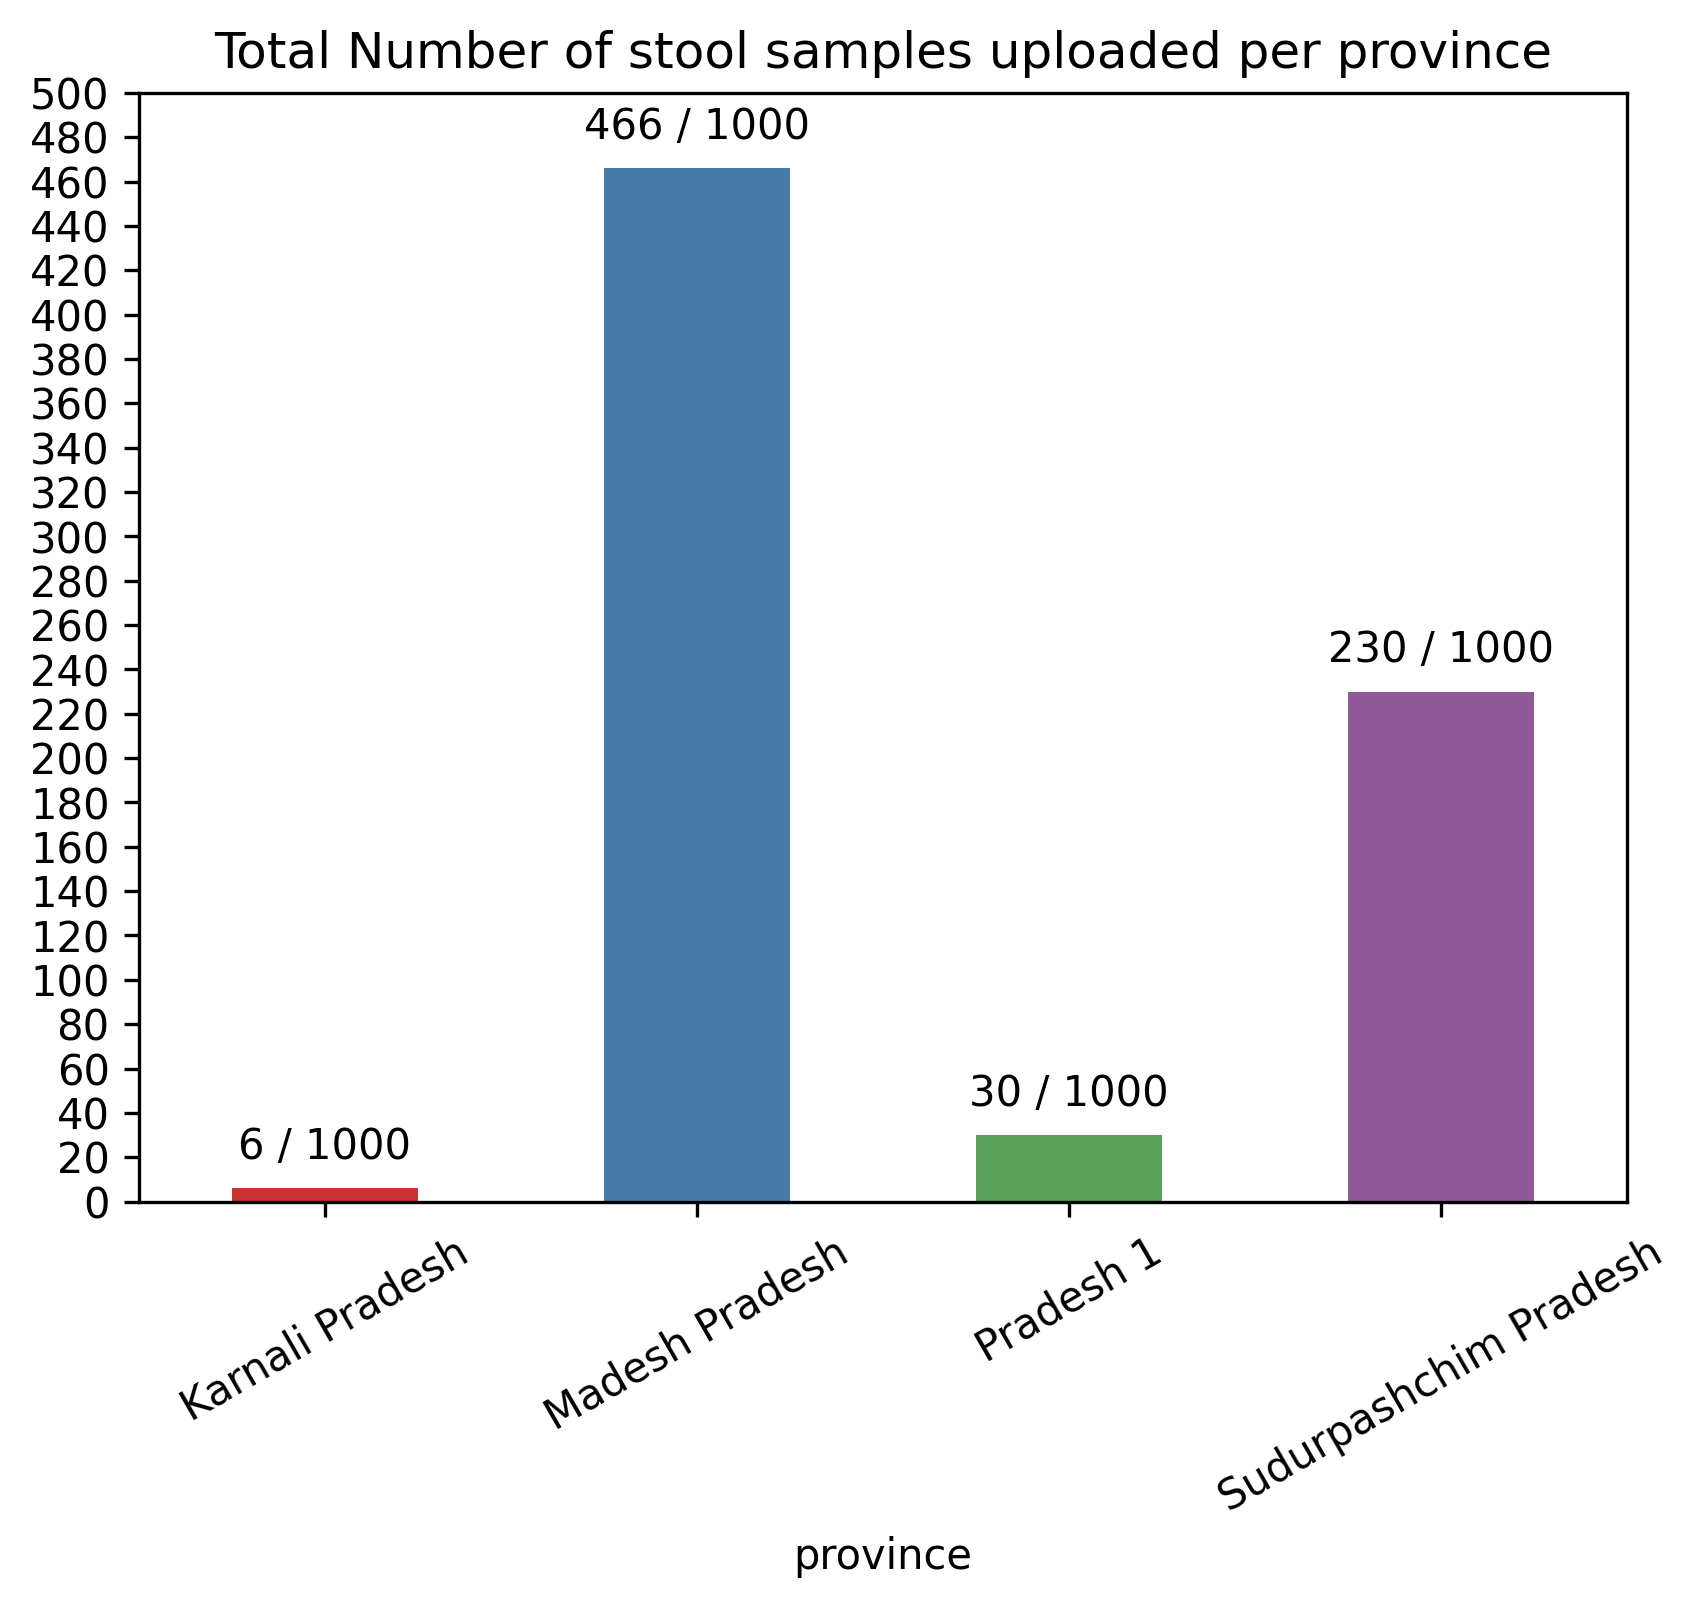

In [9]:
target_count = 1000
sns.set_palette(sns.color_palette("Set1"))
# bar plot
plt.figure(dpi=300)
stool_bar = sns.barplot(x=stats_df.index, y=stats_df.values)

# decrease bar width
for patch in stool_bar.patches: 
    current_width = patch.get_width()
    patch.set_width(0.5)
    diff = current_width - patch.get_width()
    patch.set_x(patch.get_x() + diff * .5)

# set title
plt.title(f"Total Number of {SAMPLE_TYPE} samples uploaded per province")
# set x and y labels

# yticks and xticks
plt.xticks(rotation=30)
# plt.yticks(range(0, 30, 2))
# yticks 5 more than max value
plt.yticks(range(0, max(stats_df.values) + 50, 20))

# show count on top of each bar with count out of target, int count no float

for p in stool_bar.patches:
    stool_bar.annotate(
        str(int(p.get_height())) + " / " + str(target_count),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
    )

In [10]:
image_columns = [
    "image_id",
    "image_type",
    "created_at",
    "slide_id"
]

In [11]:
stool_image_df = pd.read_sql_query(
    "SELECT {} FROM sample_slideimage where slide_id in ( \
        SELECT id from sample_slide where {}_sample_id is not null AND image != '' \
    );".format(",".join(image_columns), SAMPLE_TYPE), con
)

In [12]:
stool_image_df

,image_id,image_type,created_at,slide_id
0,S_MP-janakpur_20230223_P75FD_S1_I1_S,S,2023-04-01 10:39:59.301468,272
1,S_MP-janakpur_20230223_P75FD_S1_I2_S,S,2023-04-01 10:39:59.316240,272
2,S_MP-janakpur_20230223_P75FD_S1_I3_S,S,2023-04-01 10:39:59.326441,272
3,S_MP-janakpur_20230223_P75FD_S1_I4_S,S,2023-04-01 10:39:59.336223,272
4,S_MP-janakpur_20230223_P75FD_S1_I5_S,S,2023-04-01 10:39:59.343591,272
...,...,...,...,...
54550,S_SP-mellekh_20231004_A3NRO_S3_I11_B,B,2023-10-04 08:07:58.885776,3481
54551,S_SP-mellekh_20231004_A3NRO_S3_I12_B,B,2023-10-04 08:07:58.889787,3481
54552,S_SP-mellekh_20231004_A3NRO_S3_I13_B,B,2023-10-04 08:07:58.893841,3481
54553,S_SP-mellekh_20231004_A3NRO_S3_I14_B,B,2023-10-04 08:07:58.897901,3481


In [13]:
stool_image_df["province"] = stool_image_df["slide_id"].apply(
    lambda x: pd.read_sql_query(
        f"SELECT name from address_province WHERE id in (SELECT province_id from address_district WHERE id in (SELECT district_id from address_municipality WHERE id in (SELECT site_id from sample_{SAMPLE_TYPE} WHERE id in (SELECT {SAMPLE_TYPE}_sample_id from sample_slide WHERE id = {x}))));",
        con,
    ).iloc[0]["name"]
)

stool_image_df["sample"] = stool_image_df["slide_id"].apply(
    lambda x: pd.read_sql_query(
        f"SELECT sample_id from sample_{SAMPLE_TYPE} WHERE id in (SELECT {SAMPLE_TYPE}_sample_id from sample_slide WHERE id = {x});",
        con,
    ).iloc[0]["sample_id"]
)

stool_image_df["date_of_collection"] = stool_image_df["slide_id"].apply(
    lambda x: pd.read_sql_query(
        f"SELECT date_of_collection from sample_{SAMPLE_TYPE} WHERE id in (SELECT {SAMPLE_TYPE}_sample_id from sample_slide WHERE id = {x});",
        con,
    ).iloc[0]["date_of_collection"]
)

In [ ]:
# change date of collection to month name and year only
stool_image_df["date_of_collection"] = pd.to_datetime(stool_image_df["date_of_collection"])
stool_image_df["date_of_collection"] = stool_image_df["date_of_collection"].dt.strftime('%B %Y')
stool_image_df

,image_id,image_type,created_at,slide_id,province,sample,date_of_collection
0,S_MP-janakpur_20230223_P75FD_S1_I1_S,S,2023-04-01 10:39:59.301468,272,Madesh Pradesh,S_MP-janakpur_20230223_P75FD,February 2023
1,S_MP-janakpur_20230223_P75FD_S1_I2_S,S,2023-04-01 10:39:59.316240,272,Madesh Pradesh,S_MP-janakpur_20230223_P75FD,February 2023
2,S_MP-janakpur_20230223_P75FD_S1_I3_S,S,2023-04-01 10:39:59.326441,272,Madesh Pradesh,S_MP-janakpur_20230223_P75FD,February 2023
3,S_MP-janakpur_20230223_P75FD_S1_I4_S,S,2023-04-01 10:39:59.336223,272,Madesh Pradesh,S_MP-janakpur_20230223_P75FD,February 2023
4,S_MP-janakpur_20230223_P75FD_S1_I5_S,S,2023-04-01 10:39:59.343591,272,Madesh Pradesh,S_MP-janakpur_20230223_P75FD,February 2023
...,...,...,...,...,...,...,...
32890,S_MP-janakpur_20230919_J61CD_S3_I13_B,B,2023-09-19 10:14:50.397385,2623,Madesh Pradesh,S_MP-janakpur_20230919_J61CD,September 2023
32891,S_MP-janakpur_20230919_J61CD_S3_I14_S,S,2023-09-19 10:34:52.098518,2623,Madesh Pradesh,S_MP-janakpur_20230919_J61CD,September 2023
32892,S_MP-janakpur_20230919_J61CD_S3_I14_B,B,2023-09-19 10:14:50.404355,2623,Madesh Pradesh,S_MP-janakpur_20230919_J61CD,September 2023
32893,S_MP-janakpur_20230919_J61CD_S3_I15_S,S,2023-09-19 10:34:52.110238,2623,Madesh Pradesh,S_MP-janakpur_20230919_J61CD,September 2023


In [ ]:
# group by province, and sample type
stool_image_stats_df = stool_image_df.groupby(
    ["date_of_collection", "image_type", "province", "sample"]
).count()


In [ ]:
# rename B to Brightfield, and S to Smartphone
stool_image_stats_df = stool_image_stats_df.rename(index={"B": "Brightfield", "S": "Smartphone"})

In [ ]:
# iterate over (province, image_type) and get count of samples
stool_image_stats_df = stool_image_stats_df.groupby(["date_of_collection", "image_type", "province"]).count()


In [ ]:
# replace any one column with total
stool_image_stats_df = stool_image_stats_df.rename(columns={"image_id": "samples"})

In [ ]:
stool_image_stats_df

samples  created_at  \
date_of_collection image_type  province                                     
April 2023         Brightfield Sudurpashchim Pradesh       17          17   
                   Smartphone  Madesh Pradesh               8           8   
                               Sudurpashchim Pradesh       17          17   
August 2023        Brightfield Madesh Pradesh              88          88   
                               Pradesh 1                   13          13   
                   Smartphone  Karnali Pradesh              4           4   
                               Madesh Pradesh              89          89   
                               Pradesh 1                   13          13   
                               Sudurpashchim Pradesh       35          35   
February 2023      Smartphone  Madesh Pradesh               1           1   
July 2023          Brightfield Sudurpashchim Pradesh        7           7   
                   Smartphone  Karnali Pradesh              1           1   
                               Sudurpashchim Pradesh       27          27   
June 2023          Brightfield Sudurpashchim Pradesh       19          19   
                   Smartphone  Sudurpashchim Pradesh       37          37   
March 2023         Smartphone  Madesh Pradesh               1           1   
May 2023           Brightfield Madesh Pradesh              45          45   
                   Smartphone  Madesh Pradesh              47          47   
September 2023     Brightfield Madesh Pradesh             116         116   
                   Smartphone  Karnali Pradesh              1           1   
                               Madesh Pradesh             116         116   
                               Pradesh 1                    4           4   
                               Sudurpashchim Pradesh       26          26   

                                                      slide_id  
date_of_collection image_type  province                         
April 2023         Brightfield Sudurpashchim Pradesh        17  
                   Smartphone  Madesh Pradesh                8  
                               Sudurpashchim Pradesh        17  
August 2023        Brightfield Madesh Pradesh               88  
                               Pradesh 1                    13  
                   Smartphone  Karnali Pradesh               4  
                               Madesh Pradesh               89  
                               Pradesh 1                    13  
                               Sudurpashchim Pradesh        35  
February 2023      Smartphone  Madesh Pradesh                1  
July 2023          Brightfield Sudurpashchim Pradesh         7  
                   Smartphone  Karnali Pradesh               1  
                               Sudurpashchim Pradesh        27  
June 2023          Brightfield Sudurpashchim Pradesh        19  
                   Smartphone  Sudurpashchim Pradesh        37  
March 2023         Smartphone  Madesh Pradesh                1  
May 2023           Brightfield Madesh Pradesh               45  
                   Smartphone  Madesh Pradesh               47  
September 2023     Brightfield Madesh Pradesh              116  
                   Smartphone  Karnali Pradesh               1  
                               Madesh Pradesh              116  
                               Pradesh 1                     4  
                               Sudurpashchim Pradesh        26

In [ ]:
# months name and year from october 2022 to June 2023
months = {
    "November 2022": "Nov 22",
    "December 2022": "Dec 22",
    "January 2023": "Jan 23",
    "February 2023": "Feb 23",
    "March 2023": "Mar 23",
    "April 2023": "Apr 23",
    "May 2023": "May 23",
    "June 2023": "Jun 23",
    "July 2023": "Jul 23"
}


In [ ]:
# if month is not in stool_image_stats_df, add index for that month, image_type, province and sample
for month in months.keys():
    for image_type in ["Brightfield", "Smartphone"]:
        for province in stool_image_stats_df.index.levels[2]:
                if (month, image_type, province) not in stool_image_stats_df.index:
                    stool_image_stats_df.loc[(month, image_type, province)] = 0

In [ ]:
stool_image_stats_df = stool_image_stats_df.groupby(["date_of_collection", "image_type", "province"]).sum()

In [ ]:
provinces = stool_image_stats_df.index.levels[2]
colors = {}
for province in provinces:
    colors[province] = sns.color_palette("Set2")[list(provinces).index(province)]

In [ ]:
# total samples collected per province
total_by_province = stool_image_stats_df.groupby(["province"]).sum()
total_by_province

,samples,created_at,slide_id
province,,,
Karnali Pradesh,6,6,6
Madesh Pradesh,511,511,511
Pradesh 1,30,30,30
Sudurpashchim Pradesh,185,185,185


In [ ]:
# total samples collected per image type
total_by_image_type = stool_image_stats_df.groupby(["image_type"]).sum()
total_by_image_type

,samples,created_at,slide_id
image_type,,,
Brightfield,305,305,305
Smartphone,427,427,427


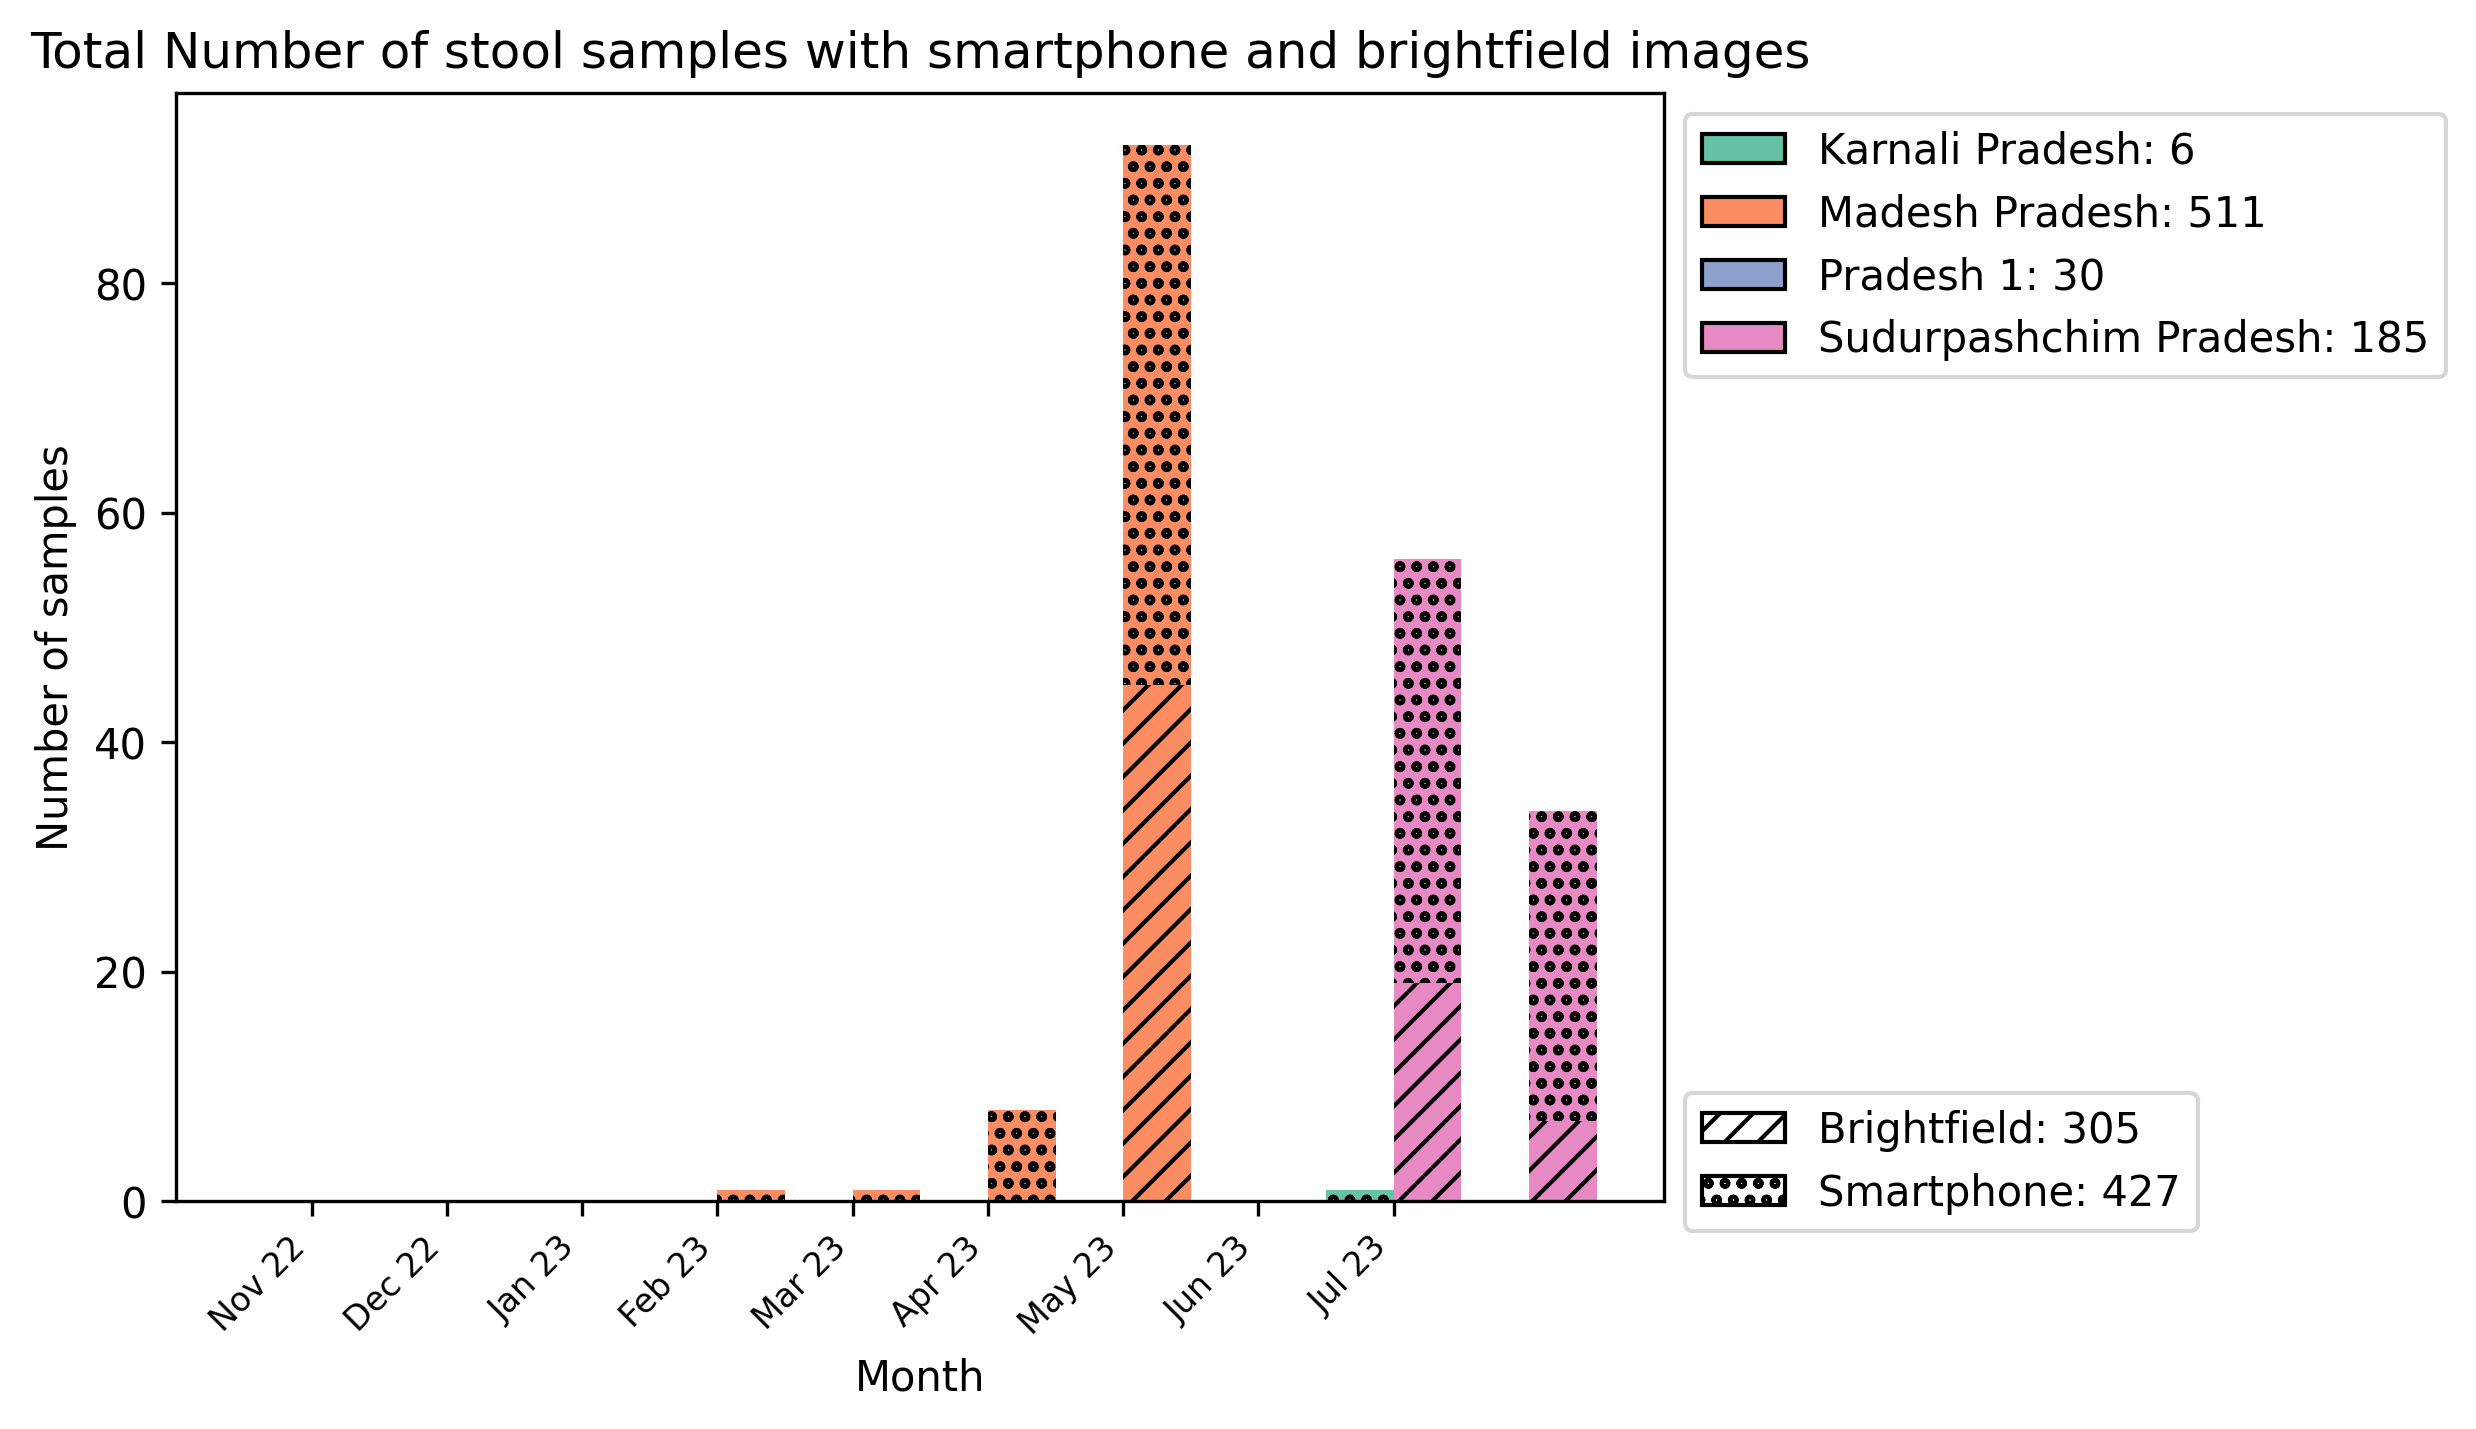

In [ ]:
from matplotlib import patches
import numpy as np
# muted color palette
# sns.set_palette(sns.color_palette("magma"))

fig, ax = plt.subplots(dpi=300)


for i, month in enumerate(months):
    # for each month add bars for provinces
    for j, province in enumerate(stool_image_stats_df.index.levels[2]):
        # individual bar for each province, each bar has two stacked bars for brightfield and smartphone
        ax.bar(
            i + j * 0.5,
            stool_image_stats_df.loc[(month, "Brightfield", province)]["samples"],
            width=0.5,
            label="Brightfield",
            color=colors[province],
            hatch="///",
        )

        ax.bar(
            i + j * 0.5,
            stool_image_stats_df.loc[(month, "Smartphone", province)]["samples"],
            width=0.5,
            bottom=stool_image_stats_df.loc[(month, "Brightfield", province)]["samples"],
            label="Smartphone",
            color= colors[province],
            # fill=False,
            hatch='ooo'
        )

# legend for each province with total samples collected
patches_province = []
for province in stool_image_stats_df.index.levels[2]:
    patches_province.append(
        patches.Patch(
            facecolor=colors[province],
            edgecolor="black",
            label="{}: {}".format(province, total_by_province.loc[province]["samples"]),
        )
    )

# add legend
ax.legend(handles=patches_province, loc="upper left", bbox_to_anchor=(1, 1))


# add xticks below the bar text
ax.set_xticks([i + 0.25 for i in range(len(months))])


ax.set_xticklabels(months.values(), rotation=45, ha="right")

styles = ["///", "ooo"]


# decrease xticks font size
plt.xticks(fontsize=8)
# set title
plt.title(f"Total Number of {SAMPLE_TYPE} samples with smartphone and brightfield images")
# set x and y labels
plt.xlabel("Month")
plt.ylabel("Number of samples")


# create another axes for legend
ax2 = fig.add_axes([0.8, 0.1, 0.1, 0.1], frameon=False)
# remove x and y ticks
ax2.set_xticks([])
ax2.set_yticks([])
# remove x and y labels
ax2.set_xlabel("")
ax2.set_ylabel("")
# remove x and y tick labels
ax2.set_xticklabels([])
ax2.set_yticklabels([])
# add legend for image type
patches_image_type = []
for image_type in stool_image_stats_df.index.levels[1]:
    patches_image_type.append(
        patches.Patch(
            facecolor="white",
            edgecolor="black",
            label="{}: {}".format(image_type, total_by_image_type.loc[image_type]["samples"]),
            hatch=styles[list(stool_image_stats_df.index.levels[1]).index(image_type)]
        )
    )

ax2.legend(handles=patches_image_type, loc="upper left", bbox_to_anchor=(1, 1));



In [ ]:
last_week = pd.Timestamp.today() - pd.Timedelta(days=7)

In [ ]:
# get str date
last_week_str = last_week.strftime("%Y-%m-%d")
last_week_str

'2023-09-13'

In [ ]:
# number of sample images created in the last one week
images_in_last_week = stool_image_df[stool_image_df["created_at"] > last_week_str].groupby(["province", "image_type"]).count()["image_id"]

In [ ]:
images_in_last_week

province               image_type
Karnali Pradesh        S               45
Madesh Pradesh         B             2070
                       S             2070
Pradesh 1              S               45
Sudurpashchim Pradesh  S              405
Name: image_id, dtype: int64

In [ ]:
# samples in last week
samples_in_last_week = stool_df[stool_df["date_of_collection"] > last_week_str].groupby("province").count()["id"]

In [ ]:
samples_in_last_week

province
Madesh Pradesh           45
Pradesh 1                 2
Sudurpashchim Pradesh     4
Name: id, dtype: int64

In [ ]:
con.close()

In [ ]:
# get number of stool images by province and image type
stool_image_stats_df = stool_image_df.groupby(["image_type", "province"]).count()

In [ ]:
stool_image_stats_df

image_id  created_at  slide_id  sample  \
image_type province                                                        
B          Madesh Pradesh            11205       11205     11205   11205   
           Pradesh 1                   585         585       585     585   
           Sudurpashchim Pradesh      1920        1920      1920    1920   
S          Karnali Pradesh             270         270       270     270   
           Madesh Pradesh            11790       11790     11790   11790   
           Pradesh 1                   765         765       765     765   
           Sudurpashchim Pradesh      6360        6360      6360    6360   

                                  date_of_collection  
image_type province                                   
B          Madesh Pradesh                      11205  
           Pradesh 1                             585  
           Sudurpashchim Pradesh                1920  
S          Karnali Pradesh                       270  
           Madesh Pradesh                      11790  
           Pradesh 1                             765  
           Sudurpashchim Pradesh                6360